In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install tensorflow-federated

In [6]:
!pip install numpy pandas

In [7]:
!pip install matplotlib

In [8]:
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Load and Preprocess the MNIST Dataset
# Load the MNIST dataset
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

# Normalize and preprocess the data
def preprocess_data(images, labels):
    images = images / 255.0  # Normalize pixel values to [0, 1]
    images = images.reshape(-1, 28, 28, 1)  # Reshape for the model input
    labels = tf.one_hot(labels, 10)  # One-hot encode the labels
    return images, labels

# Apply preprocessing
train_images, train_labels = preprocess_data(mnist_train[0], mnist_train[1])
test_images, test_labels = preprocess_data(mnist_test[0], mnist_test[1])


11490434/11490434 [==============================] - 1s 0us/step


In [10]:
# Simulate Multiple Clients
# Number of clients (simulated)
num_clients = 10

# Split data into chunks (simulate clients)
def split_data(images, labels, num_clients):
    data_size = len(images)
    client_data = []
    for i in range(num_clients):
        start = i * (data_size // num_clients)
        end = (i + 1) * (data_size // num_clients)
        client_data.append((images[start:end], labels[start:end]))
    return client_data

# Split the training data into smaller chunks for each client
client_train_data = split_data(train_images, train_labels, num_clients)


In [11]:
# Define the Model
def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model


In [13]:
# Define the Model
import tensorflow as tf
import tensorflow_federated as tff

def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

# Define a function to create the federated learning model
def model_fn():
    keras_model = create_keras_model()

    # Create a TFF model by wrapping the Keras model
    federated_model = tff.learning.from_keras_model(keras_model,
                                                    input_spec=tf.TensorSpec(shape=[None, 28, 28, 1], dtype=tf.float32),
                                                    loss=tf.keras.losses.CategoricalCrossentropy())
    return federated_model


In [15]:
!pip show tensorflow-federated


Name: tensorflow_federated
Version: 0.84.0
Summary: An open-source framework for machine learning and other computations on decentralized data.
Home-page: 
Author: 
Author-email: TensorFlow Federated Team <no-reply@google.com>
License: 
                                         Apache License
                                   Version 2.0, January 2004
                                http://www.apache.org/licenses/
        
           TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION
        
           1. Definitions.
        
              "License" shall mean the terms and conditions for use, reproduction,
              and distribution as defined by Sections 1 through 9 of this document.
        
              "Licensor" shall mean the copyright owner or entity authorized by
              the copyright owner that is granting the License.
        
              "Legal Entity" shall mean the union of the acting entity and all
              other entities that control, are c

In [21]:
import tensorflow as tf
import numpy as np
import tensorflow_federated as tff

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values to be between 0 and 1
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Add a channel dimension (for CNNs, if needed)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")

Training data shape: (60000, 28, 28, 1), Training labels shape: (60000, 10)
Test data shape: (10000, 28, 28, 1), Test labels shape: (10000, 10)


In [22]:
# Split the Data into Multiple Clients
# Function to split the data into multiple clients
def split_data_into_clients(x_data, y_data, num_clients):
    # Shuffle the data
    indices = np.arange(len(x_data))
    np.random.shuffle(indices)
    
    x_shuffled = x_data[indices]
    y_shuffled = y_data[indices]
    
    # Split the data into chunks for each client
    x_client_data = np.array_split(x_shuffled, num_clients)
    y_client_data = np.array_split(y_shuffled, num_clients)
    
    return list(zip(x_client_data, y_client_data))

# Number of clients (e.g., 10 clients)
num_clients = 10
client_data = split_data_into_clients(x_train, y_train, num_clients)

# Check the size of each client's data
for i, (x, y) in enumerate(client_data):
    print(f"Client {i+1} has {len(x)} samples")

Client 1 has 6000 samples
Client 2 has 6000 samples
Client 3 has 6000 samples
Client 4 has 6000 samples
Client 5 has 6000 samples
Client 6 has 6000 samples
Client 7 has 6000 samples
Client 8 has 6000 samples
Client 9 has 6000 samples
Client 10 has 6000 samples


In [23]:
# Prepare the Data for Federated Learning
# Function to preprocess and convert data to TensorFlow datasets
def preprocess(client_data):
    def preprocess_fn(x_data, y_data):
        # Convert numpy arrays to TensorFlow dataset
        ds = tf.data.Dataset.from_tensor_slices((x_data, y_data))
        # Shuffle and batch the data
        ds = ds.shuffle(buffer_size=100).batch(32)
        return ds

    # Apply preprocessing to each client's data
    return [preprocess_fn(x, y) for x, y in client_data]

# Preprocess the data for each client
client_datasets = preprocess(client_data)

In [24]:
# Define the Model
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),  # Input shape for MNIST
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # 10 classes for MNIST
    ])

# Wrap the Keras model for use with TFF
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )

In [25]:
 # Build the Federated Learning Process
# Build the federated averaging process
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

In [27]:
 # Initialize the Federated Learning Process
state = iterative_process.initialize()

In [29]:
#  Train the Model in a Federated Manner
# Train the model for a number of rounds
NUM_ROUNDS = 10

for round_num in range(1, NUM_ROUNDS + 1):
    # Sample a subset of clients to participate in this round
    sampled_clients = list(np.random.choice(client_datasets, size=5, replace=False))  # Convert to a Python list
    
    # Perform one round of federated training
    result = iterative_process.next(state, sampled_clients)
    state = result.state
    metrics = result.metrics
    
    # Print the metrics for this round
    print(f'Round {round_num}, Metrics: {metrics}')

Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.71853334), ('loss', 1.1268263), ('num_examples', 30000), ('num_batches', 940)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8785667), ('loss', 0.40632194), ('num_examples', 30000), ('num_batches', 940)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.8948), ('loss', 0.35099944), ('num_examples', 30000), ('num_batches', 940)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict

In [37]:
# Evaluate the Model
# Prepare the test dataset
# Prepare the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [38]:
# Extract Trained Weights from the Federated State

# Function to create a standalone Keras model from the federated state
def create_standalone_model(state, model_fn):
    # Create a new Keras model
    keras_model = create_keras_model()
    
    # Extract the weights from the federated state
    state.global_model_weights.assign_weights_to(keras_model)
    
    return keras_model

# Create the standalone Keras model
standalone_model = create_standalone_model(state, model_fn)

In [39]:
 # Evaluate the Standalone Model
# Compile the standalone model
standalone_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = standalone_model.evaluate(test_dataset)

# Print the evaluation metrics
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

313/313 [==============================] - 1s 3ms/step - loss: 0.1689 - categorical_accuracy: 0.9489
Test Loss: 0.16892866790294647, Test Accuracy: 0.9488999843597412


1/1 [==============================] - 0s 73ms/step


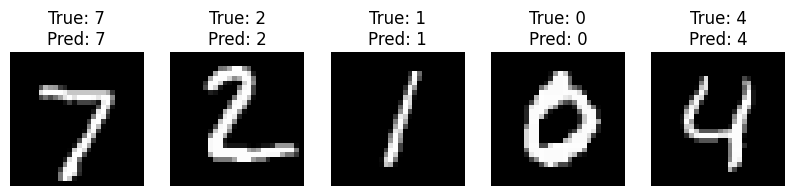

In [40]:
# Visualize Predictions
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, test_images, test_labels, num_samples=5):
    predictions = model.predict(test_images[:num_samples])
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels[:num_samples], axis=1)
    
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(standalone_model, x_test, y_test, num_samples=5)